In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
seattle = pd.read_csv('seattleWeather_1948-2017.csv', parse_dates=['DATE'])
seattle.columns = ['date', 'prcp', 't_max', 't_min', 'rain']
seattle = seattle.reset_index(drop=True).set_index('date')
seattle.prcp.fillna(0, inplace=True)
seattle.rain.fillna(False, inplace=True)
seattle

,prcp,t_max,t_min,rain
date,,,,
1948-01-01,0.47,51,42,True
1948-01-02,0.59,45,36,True
1948-01-03,0.42,45,35,True
1948-01-04,0.31,45,34,True
1948-01-05,0.17,45,32,True
...,...,...,...,...
2017-12-10,0.00,49,34,False
2017-12-11,0.00,49,29,False
2017-12-12,0.00,46,32,False


In [3]:
seattle.t_min = (seattle.t_min - 32) * 5 / 9
seattle.t_max = (seattle.t_max - 32) * 5 / 9
seattle

,prcp,t_max,t_min,rain
date,,,,
1948-01-01,0.47,10.555556,5.555556,True
1948-01-02,0.59,7.222222,2.222222,True
1948-01-03,0.42,7.222222,1.666667,True
1948-01-04,0.31,7.222222,1.111111,True
1948-01-05,0.17,7.222222,0.000000,True
...,...,...,...,...
2017-12-10,0.00,9.444444,1.111111,False
2017-12-11,0.00,9.444444,-1.666667,False
2017-12-12,0.00,7.777778,0.000000,False


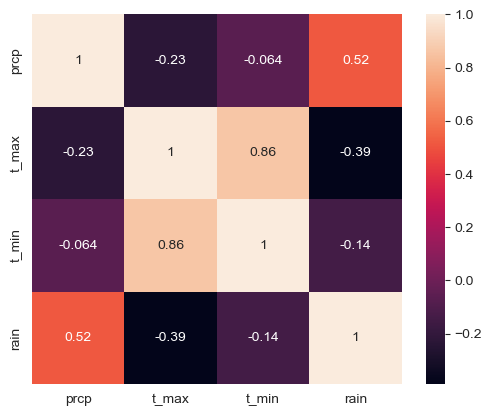

In [4]:
sns.heatmap(seattle.corr(), annot=True, square=True);

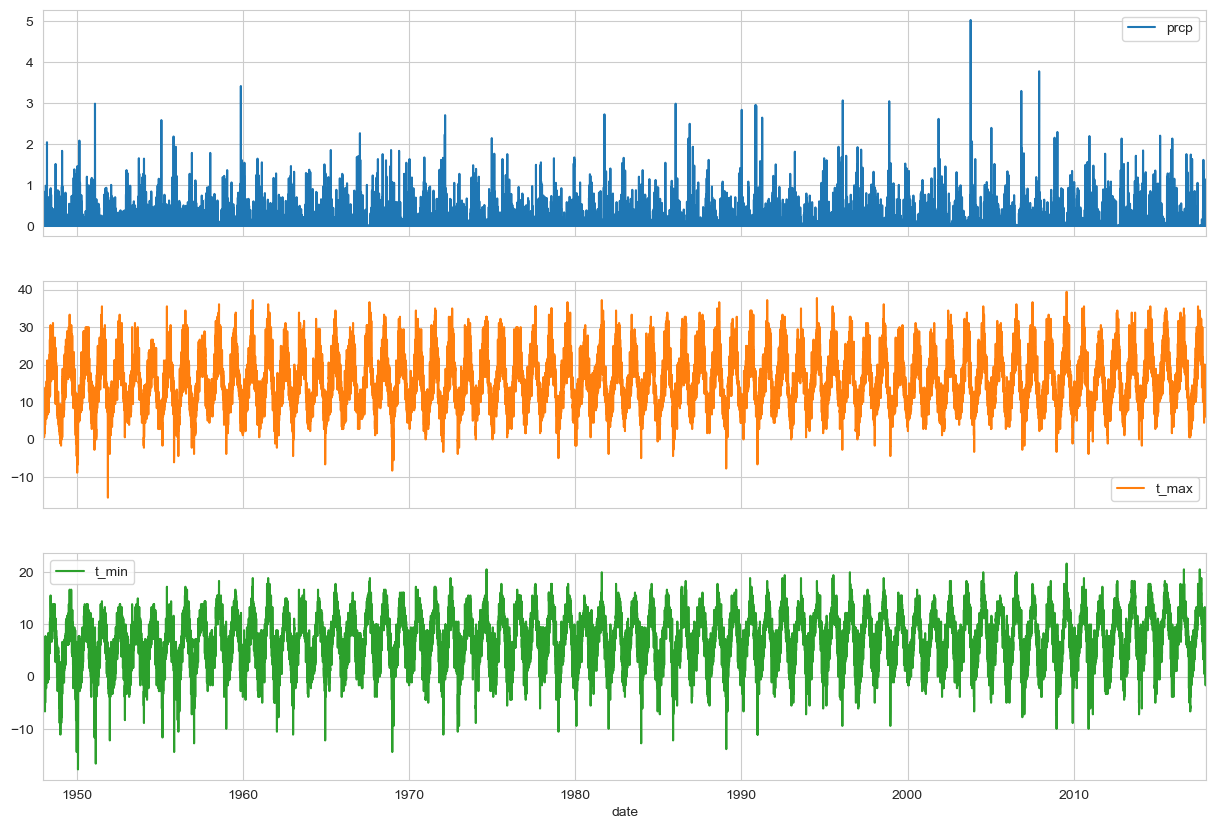

In [5]:
seattle.plot(subplots=True, figsize=(15, 10));

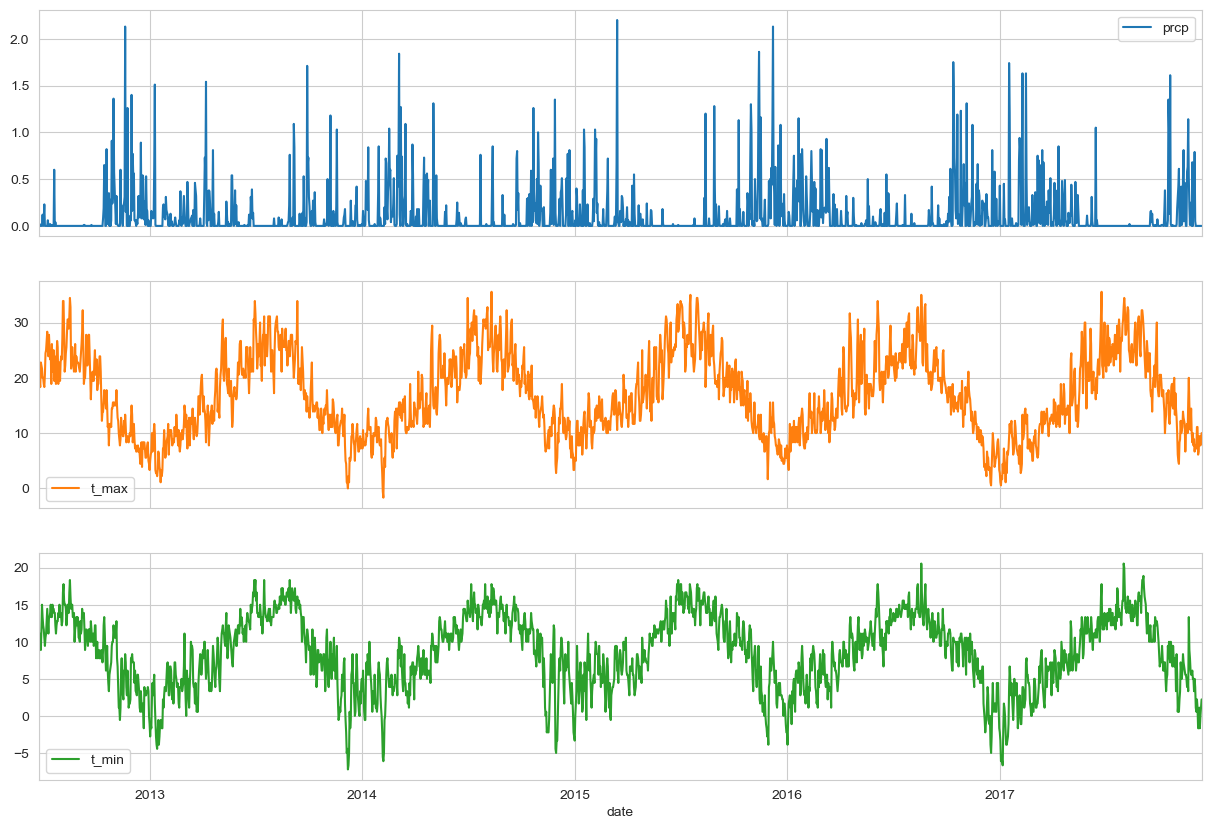

In [6]:
seattle.iloc[-2000:].plot(subplots=True, figsize=(15, 10));

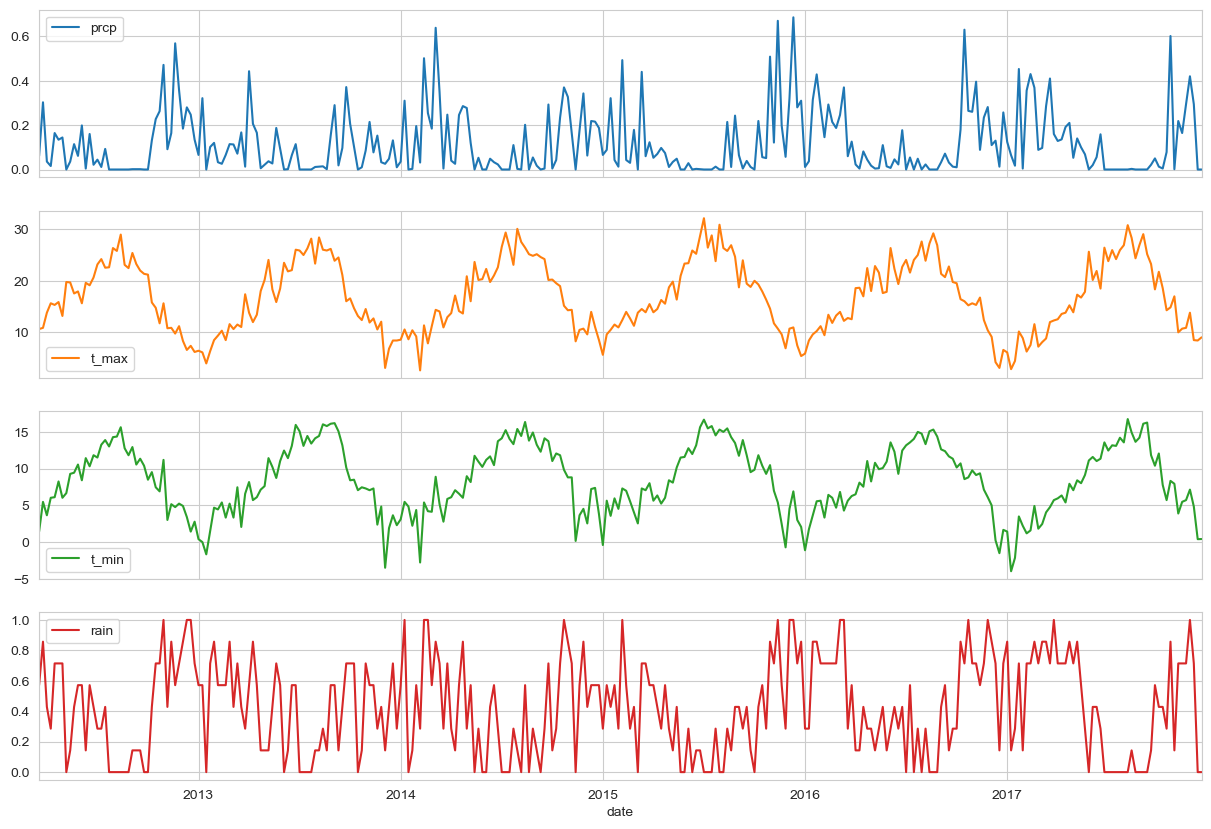

In [7]:
seattle_weeks = seattle.resample('W').mean()
seattle_weeks.iloc[-300:].plot(subplots=True, figsize=(15, 10));

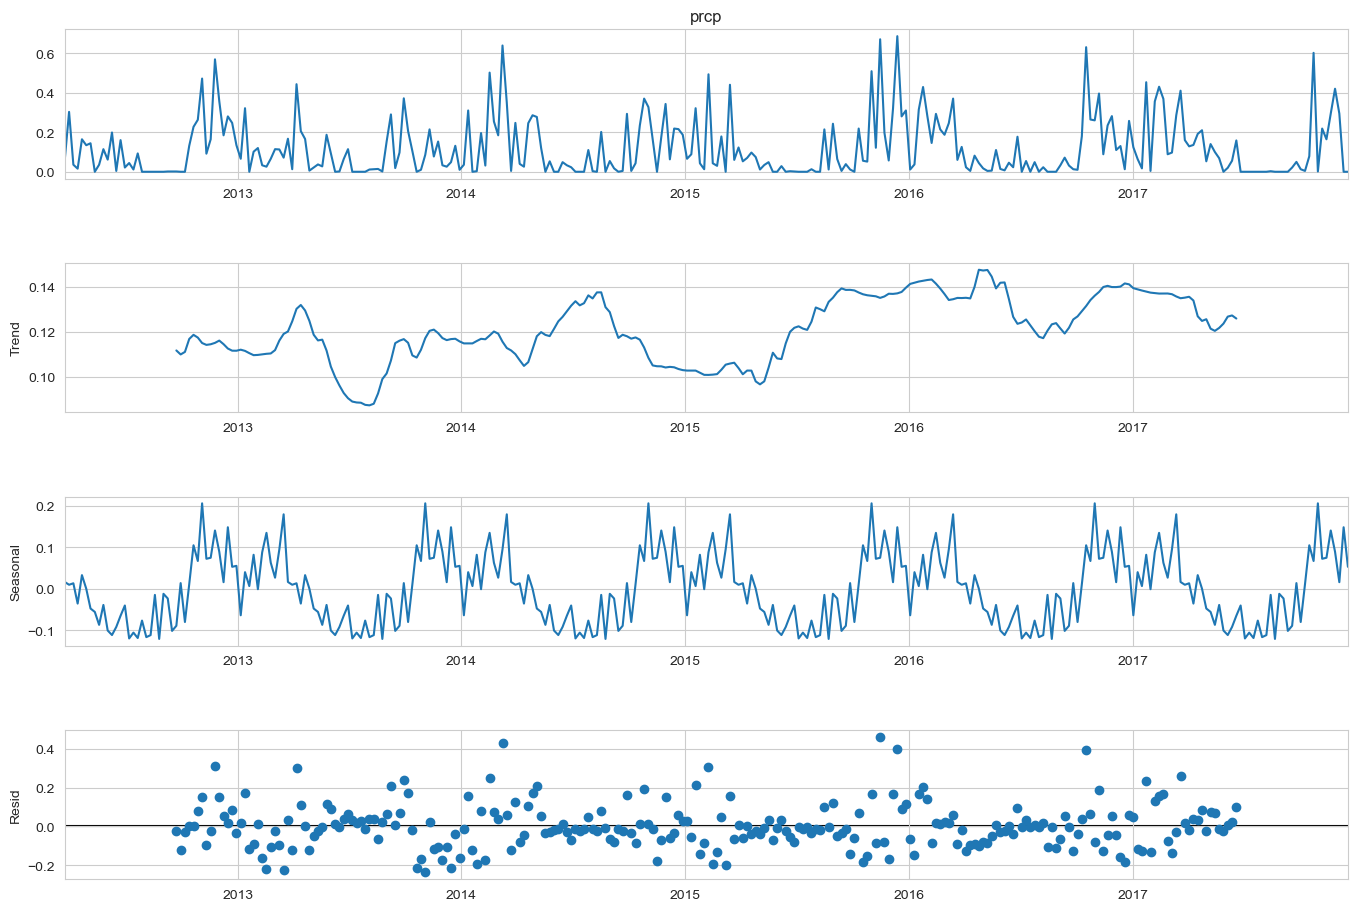

In [8]:
smt.seasonal_decompose(seattle_weeks.iloc[-300:].prcp).plot().set_size_inches(15, 10)

In [9]:
def dickey_fuller_test(series):
    adf, p_value, usedlag, nobs, critical_vales, icbest = smt.adfuller(series, autolag='AIC')
    print('adf: ', adf)
    print('p-value: ', p_value)
    print('Critical values: ', critical_vales)
    if adf < critical_vales['5%'] and p_value < 0.05:
        print('Одиничні корені відсутні, ряд є стаціонарним.')
        return True
    else:
        print('Навні одиничні корені, ряд не стаціонарний.')
    return False

In [10]:
dickey_fuller_test(seattle_weeks.prcp);

adf:  -18.57958491656519
p-value:  2.078583601676372e-30
Critical values:  {'1%': -3.4321572194957715, '5%': -2.862338528678273, '10%': -2.567195069249532}
Одиничні корені відсутні, ряд є стаціонарним.


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


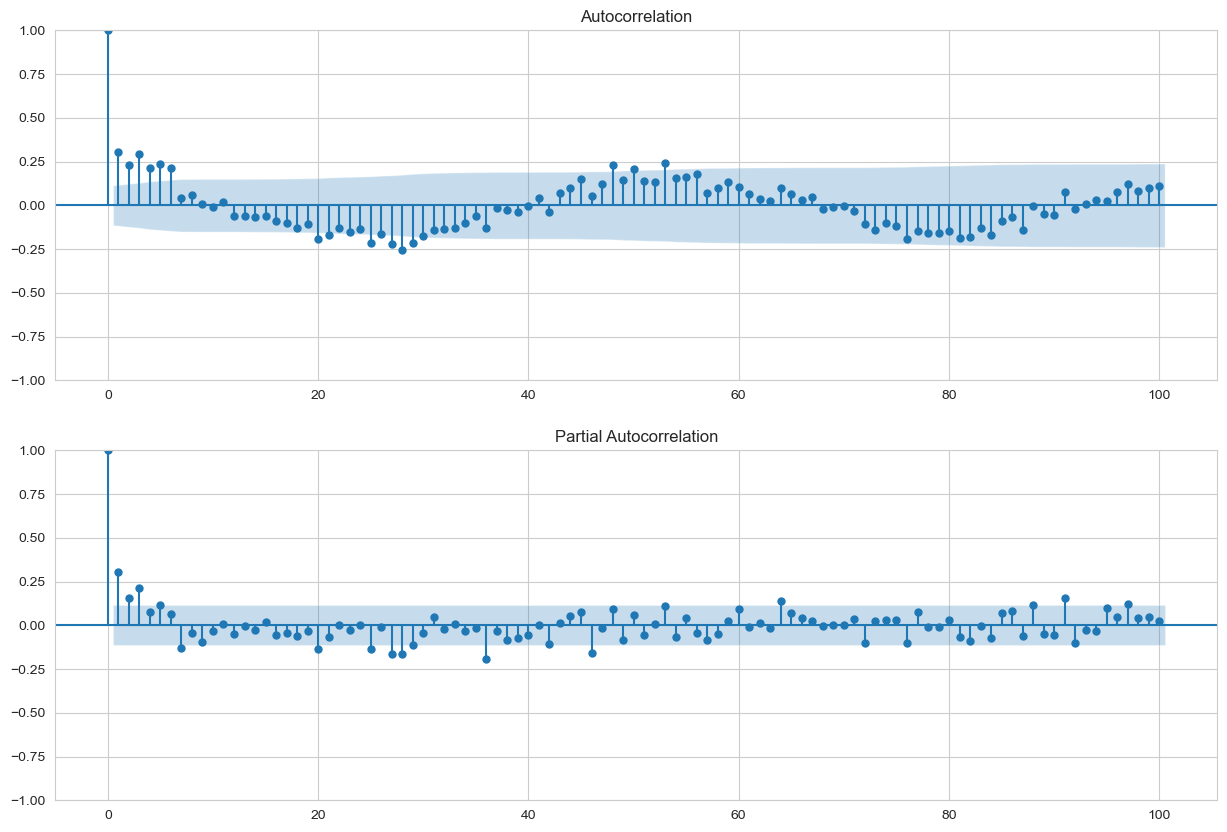

In [11]:
_, axes = plt.subplots(2, figsize=(15, 10))
plot_acf(seattle_weeks.prcp.iloc[-300:], ax=axes[0], lags=100)
plot_pacf(seattle_weeks.prcp.iloc[-300:], ax=axes[1], lags=100);

In [12]:
seattle_train = seattle.loc[:'2009-12-31']
seattle_train

,prcp,t_max,t_min,rain
date,,,,
1948-01-01,0.47,10.555556,5.555556,True
1948-01-02,0.59,7.222222,2.222222,True
1948-01-03,0.42,7.222222,1.666667,True
1948-01-04,0.31,7.222222,1.111111,True
1948-01-05,0.17,7.222222,0.000000,True
...,...,...,...,...
2009-12-27,0.00,6.666667,-2.222222,False
2009-12-28,0.00,9.444444,1.666667,False
2009-12-29,0.06,6.111111,-1.111111,True


In [13]:
seattle_test = seattle.loc['2010-01-01':'2016-12-31']
seattle_test

,prcp,t_max,t_min,rain
date,,,,
2010-01-01,0.40,11.111111,7.222222,True
2010-01-02,0.06,8.333333,6.111111,True
2010-01-03,0.03,8.888889,3.888889,True
2010-01-04,0.98,9.444444,6.666667,True
2010-01-05,0.14,10.000000,6.666667,True
...,...,...,...,...
2016-12-27,0.05,6.666667,4.444444,True
2016-12-28,0.00,8.333333,3.333333,False
2016-12-29,0.05,8.888889,4.444444,True


In [14]:
model_stepwise = auto_arima(
    seattle_train.iloc[-2000:].prcp,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    seasonal=True,
    m=12,
    start_P=0,
    d=None,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=14.20 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1436.526, Time=0.97 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=639.034, Time=10.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=19.67 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1434.530, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1239.510, Time=0.56 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=443.552, Time=19.49 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=68.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=17.12 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=654.894, Time=17.51 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=429.933, Time=22.38 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=622.940, Time=9.35 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=80.06 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=24.80 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=4

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2000
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 12)   Log Likelihood                -203.424
Date:                             Wed, 24 May 2023   AIC                            418.849
Time:                                     01:59:47   BIC                            452.418
Sample:                                 07-11-2004   HQIC                           431.178
                                      - 12-31-2009                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7412      0.055     13.435      0.000       0.633       0.849
ma.L1         -0.4580      0.056     -8.207      0.000      -0.567      -0.349
ma.L2         -0.0616      0.024     -2.594      0.009      -0.108      -0.015
ar.S.L12      -0.6787      0.011    -63.242      0.000      -0.700      -0.658
ar.S.L24      -0.3129      0.012    -26.309      0.000      -0.336      -0.290
sigma2         0.0716      0.001    100.829      0.000       0.070       0.073
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             67864.66
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             3.07
Prob(H) (two-sided):                  0.83   Kurtosis:                        30.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
sarimax_model = SARIMAX(seattle_train.prcp, order=(1, 0, 2), seasonal_order=(2, 1, 0, 12), D=1).fit()
sarimax_model.summary()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                prcp   No. Observations:                22646
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 12)   Log Likelihood               -1156.040
Date:                             Wed, 24 May 2023   AIC                           2324.079
Time:                                     02:00:23   BIC                           2372.243
Sample:                                 01-01-1948   HQIC                          2339.743
                                      - 12-31-2009                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6519      0.032     20.563      0.000       0.590       0.714
ma.L1         -0.3960      0.032    -12.458      0.000      -0.458      -0.334
ma.L2         -0.0765      0.011     -6.889      0.000      -0.098      -0.055
ar.S.L12      -0.6782      0.003   -216.514      0.000      -0.684      -0.672
ar.S.L24      -0.3304      0.003   -108.155      0.000      -0.336      -0.324
sigma2         0.0648      0.000    347.202      0.000       0.064       0.065
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            497663.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             2.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

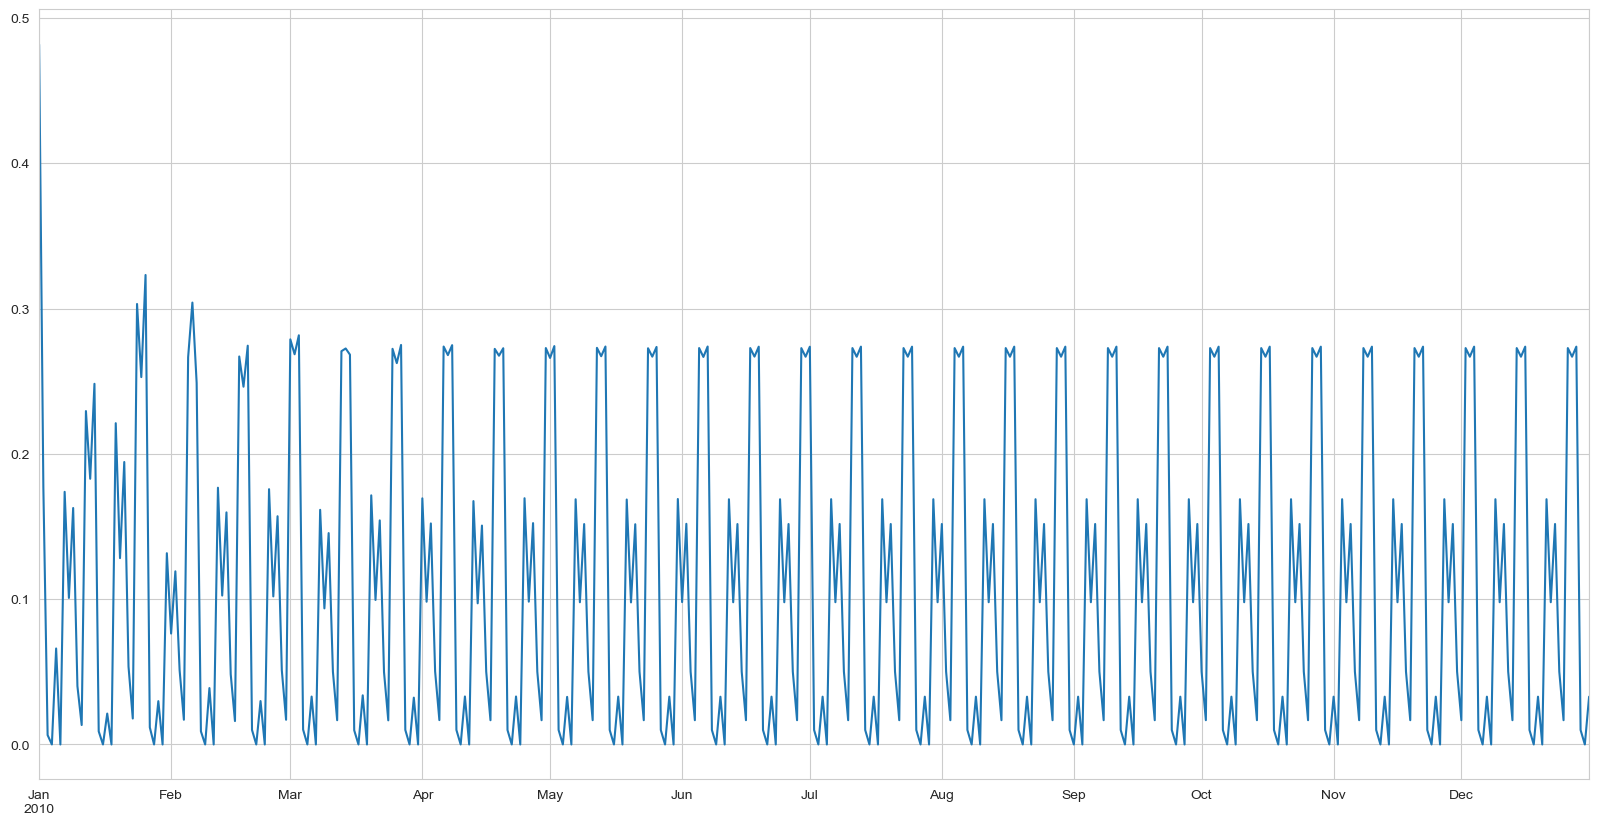

In [16]:
_, ax = plt.subplots(figsize=(20, 10))
sarimax_model.forecast(365).plot(ax=ax)
# seattle_train.iloc[-500:].prcp.plot(ax=ax)

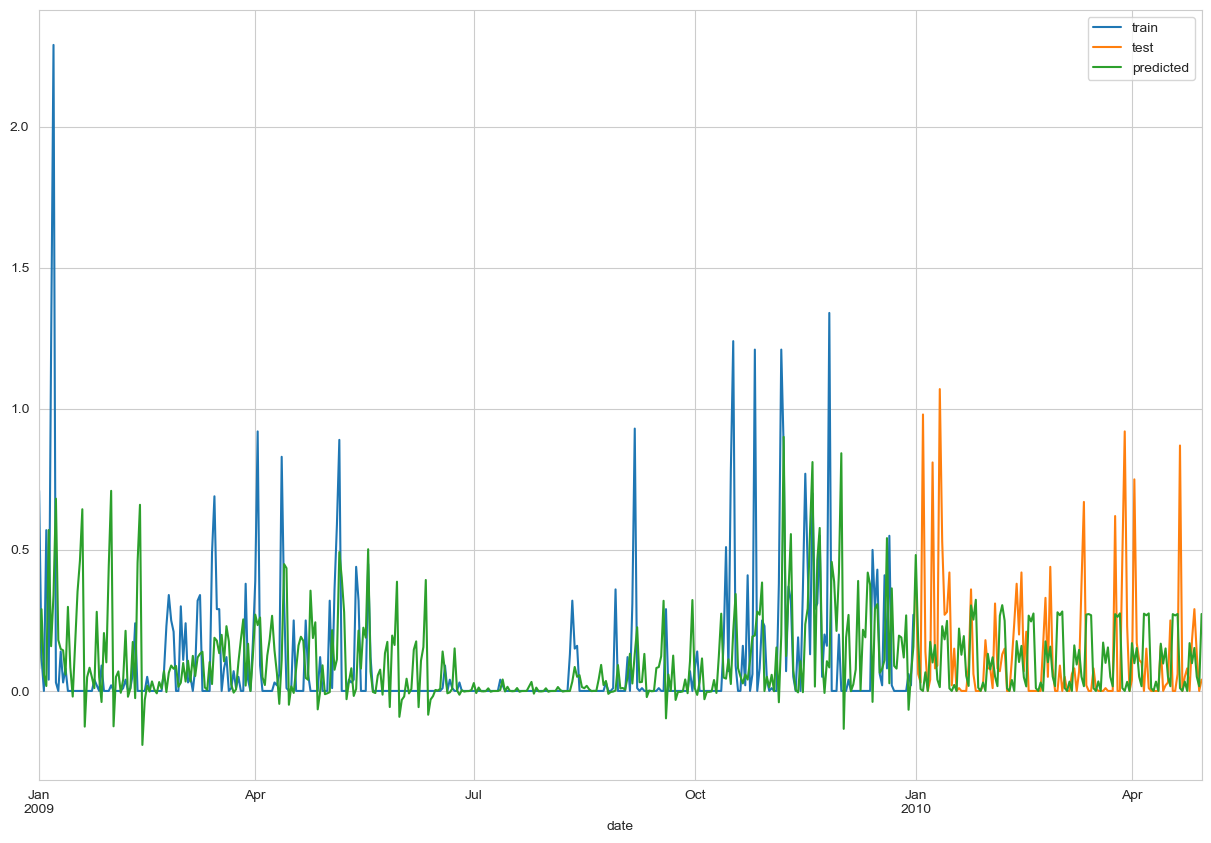

In [17]:
_, ax = plt.subplots(figsize=(15, 10))
seattle_train.iloc[-365:].prcp.plot(ax=ax)
seattle_test.iloc[:120].prcp.plot(ax=ax)
sarimax_model.predict(start='2009-01-01', end='2010-04-30', dynamic=False).plot(ax=ax)
ax = ax.legend(['train', 'test', 'predicted'])

02:00:28 - cmdstanpy - INFO - Chain [1] start processing
02:00:40 - cmdstanpy - INFO - Chain [1] done processing


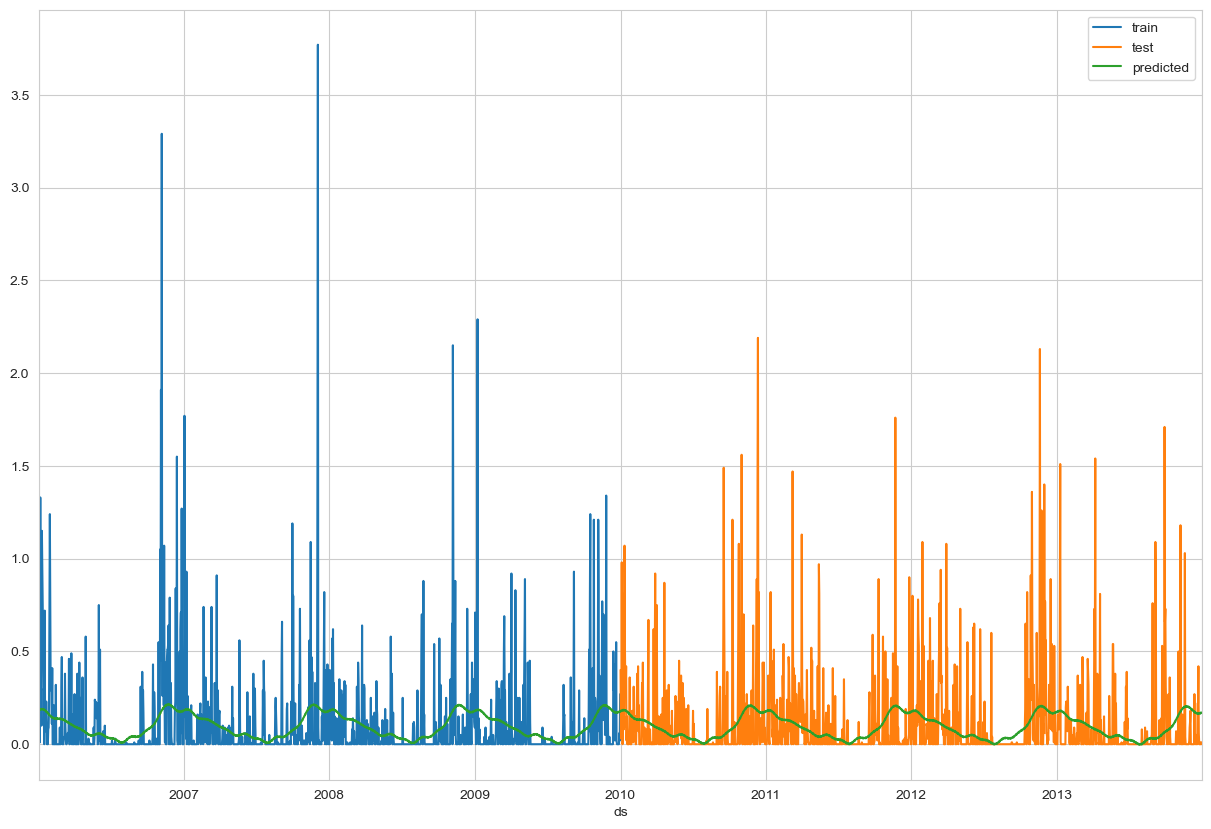

In [18]:
prophet_model = Prophet(changepoint_prior_scale=5)

prophet_train = pd.DataFrame({
    'ds': seattle_train.index,
    'y': seattle_train.prcp
}).reset_index(drop=True)

prophet_model.fit(prophet_train)

prophet_predictions = prophet_model.predict(prophet_model.make_future_dataframe(365 * 4))
prophet_visualization = prophet_predictions.copy(deep=True)
prophet_predictions = prophet_predictions.reset_index(drop=True).set_index('ds').yhat

_, ax = plt.subplots(figsize=(15, 10))
prophet_train.iloc[-365 * 4:].plot(ax=ax, x='ds', y='y')
seattle_test.iloc[:365 * 4].prcp.plot(ax=ax)
prophet_predictions.iloc[-365 * 8:].plot(ax=ax)
ax = ax.legend(['train', 'test', 'predicted'])

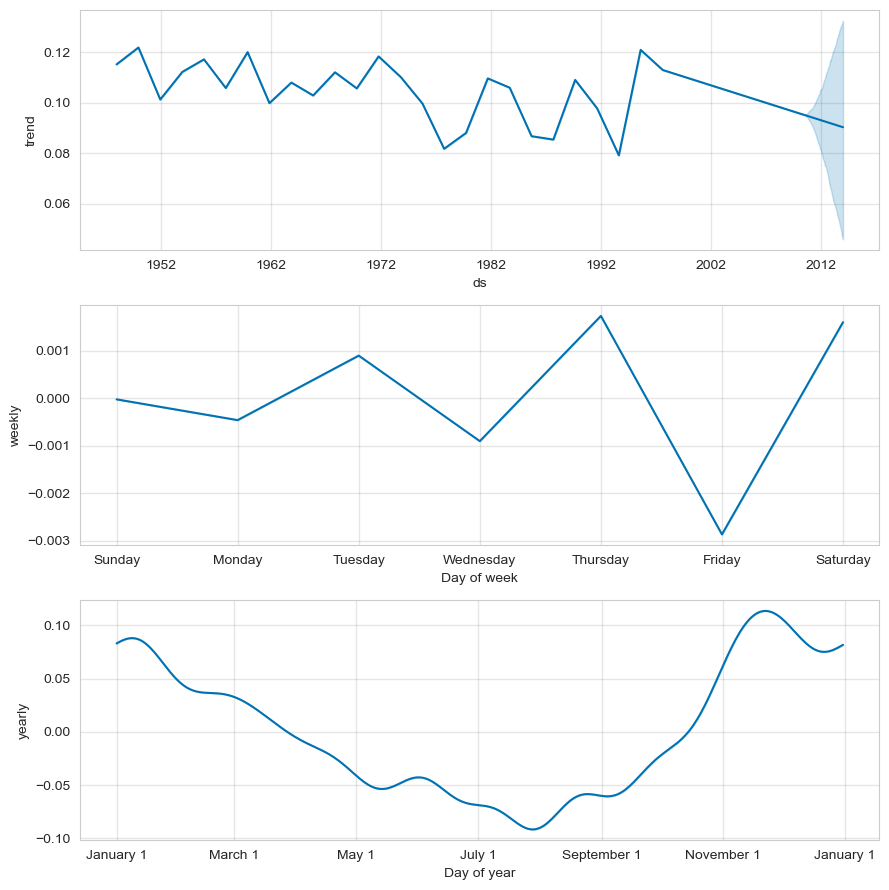

In [19]:
prophet_model.plot_components(prophet_visualization);

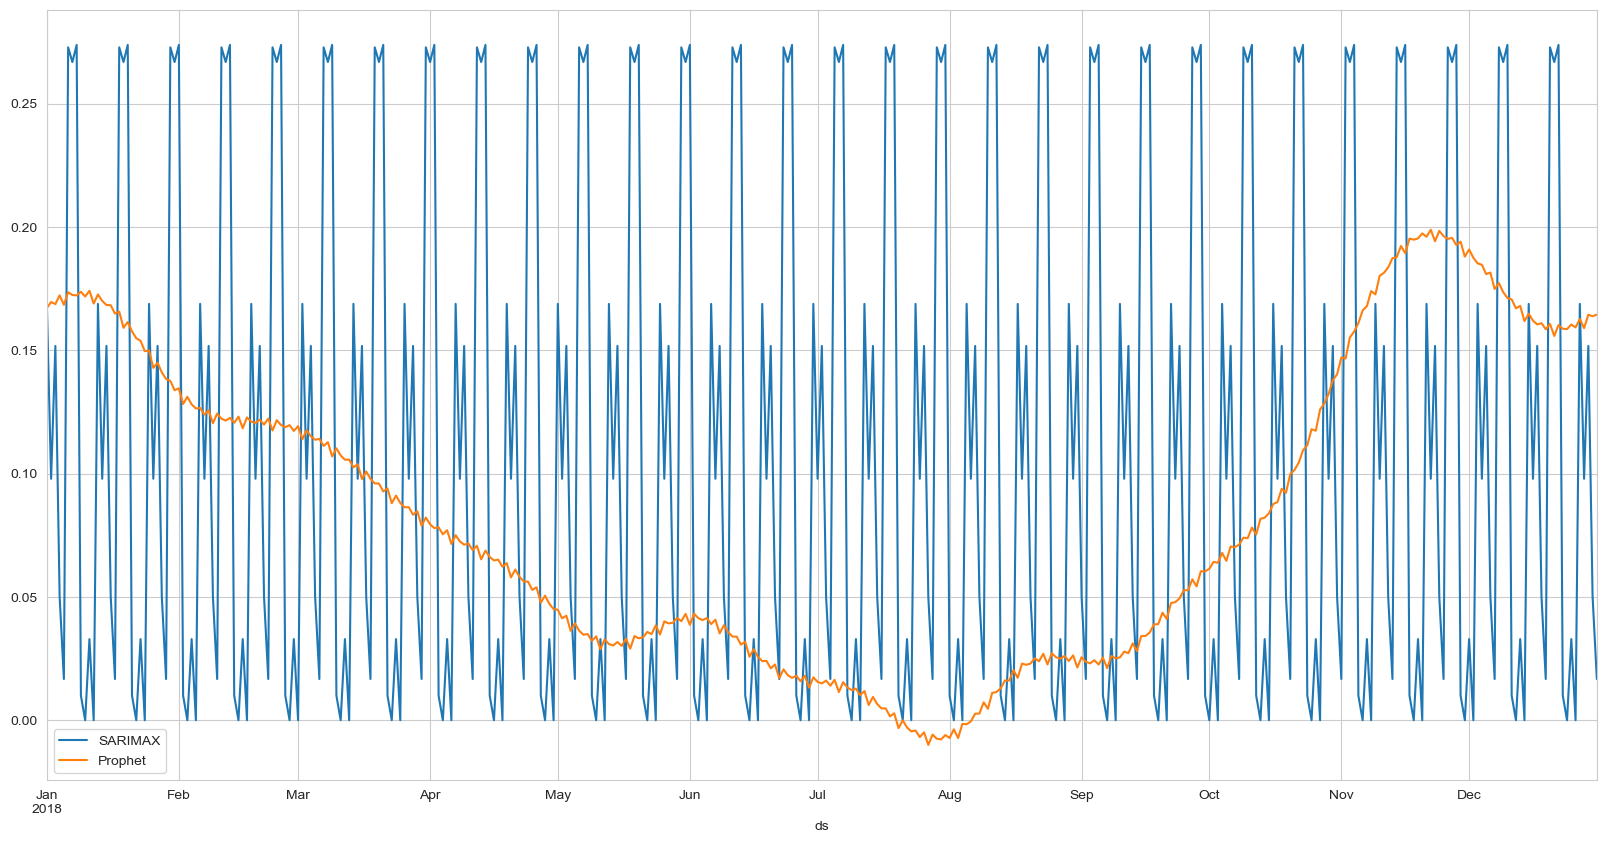

In [20]:
_, ax = plt.subplots(figsize=(20, 10))
sarimax_model.forecast(steps=(pd.to_datetime('2018-12-31') - seattle_test.index[0]).days + 1).loc['2018-01-01':'2018-12-31'].plot(ax=ax)

date_range_2018 = pd.DataFrame(pd.date_range('2018-01-01', '2018-12-31'))
date_range_2018.columns = ['ds']

prophet_model.predict(date_range_2018).set_index('ds').yhat.plot(ax=ax)

plt.legend(['SARIMAX', 'Prophet']);